### Script is designed to identify the most represented spesies with the biggest reads number per smpl
Input files are the output of kraken-report <br>
Output is the boxplot and a table <br>
You can change number of top species and per species reads threshhold

In [390]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np
import os
import glob

In [428]:
# filter species with the reads number per smple are less than:
nb = 10000
# How many species need to include in top list?
tsp = 30

In [ ]:
# You path to folders with kraken outputs files
pathD = os.path.abspath(os.path.dirname('./input/BGI_Kraken2_1908/')) 
# You can define needed file prefix (for example, 'lab*')
flist = [os.path.basename(x) for x in glob.glob(pathD + '/lab*')]

In [423]:
# Select only species
COLUMN_NAMES = ['smpl','perc', 'rn1', 'rn2', 'type', 'id', 'name']
sp = pd.DataFrame(columns=COLUMN_NAMES)

for smpl in flist:
    tax = pd.read_csv(pathD + '/' + str(smpl), sep='\t', 
                  names=["perc", "rn1", "rn2", 'type','id', "name"])
    taxU = tax[tax['type'] == 'S']
    taxU = taxU[taxU['rn1'] >= nb].sort_values(by=['rn1'], ascending=False)
    taxU = taxU.assign(smpl=smpl[6:23])
    sp = sp.append(taxU)
         
sp.head(2)

,smpl,perc,rn1,rn2,type,id,name
11,VS08GD_E100016770,12.51,6154435,6154435,S,165179,Prevotella copri
41,VS08GD_E100016770,1.52,746400,744193,S,821,Phocaeicola vulgatus


In [429]:
# how much species are present in N percent of the samples?
a = 0.99 #choose needed percentage
sn = len(sp['smpl'].unique())
blist = sp.groupby(by=["name"]).count().sort_values(by=['smpl'], ascending=False)
blistN = blist[blist['id'] >= sn*a]

print('Total number of mo: '+str(len(sp['name'].unique())))
print('Present in ' + str(a) + '% smpls: '+str(len(blistN)))

Total number of mo: 1179
Present in 0.99% smpls: 14


In [430]:
# choose top species
idlist = sp.groupby(by=["id"]).count().sort_values(by=['smpl'], ascending=False)
idlist = idlist.head(tsp)
idlist = idlist.reset_index()
list_of_values = idlist[['id']]

spA = sp[sp['id'].isin(list_of_values['id'])]
spA = spA[spA['id'] != 9606]

idlistD1 = idlist[['id','smpl']].set_index('id')
idlistD2 = idlistD1.iloc[:, -1].to_dict()
spA['Abundance'] = spA['id'].map(idlistD2)

idx = spA.groupby(by=["name"]).mean()
idx = idx.reset_index()
idx = idx.replace("\s\s+" , " ",regex=True)
idx = idx.sort_values(by=['perc'], ascending=False)

idx.to_csv('results/TopSp_'+str(tsp)+'.csv')
idx = idx.reset_index()
idx = idx[['name','perc','Abundance']]
idx.head(5)

,name,perc,Abundance
0,Phocaeicola vulgatus,4.085367,1906
1,Bacteroides uniformis,2.409186,1905
2,Faecalibacterium prausnitzii,2.167099,1903
3,Phocaeicola dorei,1.638378,1905
4,Bacteroides ovatus,0.963951,1901


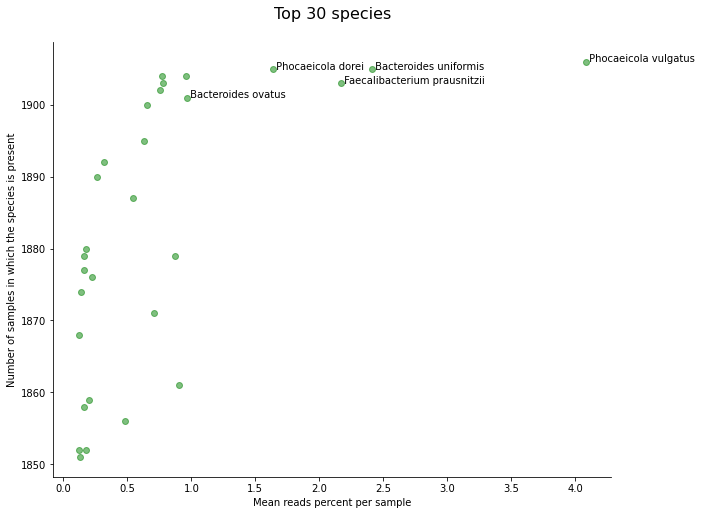

In [434]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(idx['perc'], idx['Abundance'], color = 'green', alpha=0.5)

for i, txt in enumerate(idx['name'].head(5)):
    ax.annotate(txt, (idx['perc'][i], idx['Abundance'][i]))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Top '+str(tsp)+' species'+'\n', fontsize=16)
plt.ylabel('Number of samples in which the species is present')
plt.xlabel('Mean reads percent per sample')
plt.savefig('results/Top_species_'+str(tsp)+'.png', dpi=400)